# Basic Multi-agent Collaboration

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools. 

One way to approach complicated tasks is through a "divide-and-conquer" approach: create an specialized agent for each task or domain and route tasks to the correct "expert".

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

The resulting graph will look something like the following diagram:

![multi_agent diagram](./img/simple_multi_agent_diagram.png)

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

In [1]:
// Deno.env.set("OPENAI_API_KEY", "sk_...");
// Deno.env.set("TAVILY_API_KEY", "sk_...");

// Optional, add tracing in LangSmith
// Deno.env.set("LANGCHAIN_API_KEY", "sk_...");
Deno.env.set("LANGCHAIN_TRACING_V2", "true");
Deno.env.set("LANGCHAIN_PROJECT", "Multi-agent Collaboration: LangGraphJS");

## Helper Utilities

The following helper functions will help create agents. These agents will then be nodes in the graph. 

You can skip ahead if you just want to see what the graph looks like.

In [2]:
import {
  ChatPromptTemplate,
  MessagesPlaceholder,
} from "@langchain/core/prompts";
import { Tool } from "@langchain/core/tools";
import { convertToOpenAITool } from "@langchain/core/utils/function_calling";
import { Runnable } from "@langchain/core/runnables";

/**
 * Create an agent that can run a set of tools.
 */
async function createAgent({
  llm,
  tools,
  systemMessage,
}: {
  llm: BaseLanguageModel;
  tools: Tool[];
  systemMessage: string;
}): Promise<Runnable> {
  const toolNames = tools.map((tool) => tool.name).join(", ");
  const formattedTools = tools.map((t) => convertToOpenAITool(t));

  let prompt = await ChatPromptTemplate.fromMessages([
    [
      "system",
      "You are a helpful AI assistant, collaborating with other assistants." +
        " Use the provided tools to progress towards answering the question." +
        " If you are unable to fully answer, that's OK, another assistant with different tools " +
        " will help where you left off. Execute what you can to make progress." +
        " If you or any of the other assistants have the final answer or deliverable," +
        " prefix your response with FINAL ANSWER so the team knows to stop." +
        " You have access to the following tools: {tool_names}.\n{system_message}",
    ],
    new MessagesPlaceholder("messages"),
  ]);
  prompt = await prompt.partial({
    system_message: systemMessage,
    tool_names: toolNames,
  })

  return prompt.pipe(llm.bind({ tools: formattedTools }));
}

const isToolMessage = (message) => !!message?.additional_kwargs?.tool_calls;


## Define tools

These tools will be used by our worker agents to answer our questions.

We will create a chart tool (using d3.js), and the LangChain TavilySearchResults tool for web search functionality.

In [3]:
import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { DynamicStructuredTool } from "@langchain/core/tools";
import * as d3 from "d3";
import { createCanvas } from "https://deno.land/x/skia_canvas/mod.ts";
import { z } from "zod";

const chartTool = new DynamicStructuredTool({
  name: "generate_bar_chart",
  description:
    "Generates a bar chart from an array of data points using D3.js and displays it for the user.",
  schema: z.object({
    data: z
      .object({
        label: z.string(),
        value: z.number(),
      })
      .array(),
  }),
  func: async ({data}) => {
    // const data = input.data;
    const width = 500;
    const height = 500;
    const margin = { top: 20, right: 30, bottom: 30, left: 40 };

    const canvas = createCanvas(width, height);
    const ctx = canvas.getContext("2d");

    const x = d3
      .scaleBand()
      .domain(data.map((d) => d.label))
      .range([margin.left, width - margin.right])
      .padding(0.1);

    const y = d3
      .scaleLinear()
      .domain([0, d3.max(data, (d) => d.value)])
      .nice()
      .range([height - margin.bottom, margin.top]);

    const colorPalette = [
      "#e6194B",
      "#3cb44b",
      "#ffe119",
      "#4363d8",
      "#f58231",
      "#911eb4",
      "#42d4f4",
      "#f032e6",
      "#bfef45",
      "#fabebe",
    ];

    data.forEach((d, idx) => {
      ctx.fillStyle = colorPalette[idx % colorPalette.length];
      ctx.fillRect(
        x(d.label),
         y(d.value),
        x.bandwidth(),
        height - margin.bottom - y(d.value),
      );
    });

    ctx.beginPath();
    ctx.strokeStyle = "black";
    ctx.moveTo(margin.left, height - margin.bottom);
    ctx.lineTo(width - margin.right, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "center";
    ctx.textBaseline = "top";
    x.domain().forEach((d) => {
      const xCoord = x(d) + x.bandwidth() / 2;
      ctx.fillText(d, xCoord, height - margin.bottom + 6);
    });

    ctx.beginPath();
    ctx.moveTo(margin.left, height - margin.top);
    ctx.lineTo(margin.left, height - margin.bottom);
    ctx.stroke();

    ctx.textAlign = "right";
    ctx.textBaseline = "middle";
    const ticks = y.ticks();
    ticks.forEach((d) => {
      const yCoord = y(d); // height - margin.bottom - y(d);
      ctx.moveTo(margin.left, yCoord);
      ctx.lineTo(margin.left - 6, yCoord);
      ctx.stroke();
      ctx.fillText(d, margin.left - 8, yCoord);
    });

    await Deno.jupyter.display(canvas);
    return "Chart generated";
  },
});

const tavilyTool = new TavilySearchResults();


## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

In LangGraph, nodes represent functions that perform the work. In our example, we will have "agent" nodes and a "callTool" node.

The input for every node is the graph's state. In our case, the state will have a list of messages as input, as well as the name of the previous node.

First, let's define the nodes for the agents.

In [4]:
import { ChatOpenAI } from "@langchain/openai";
import { HumanMessage } from "@langchain/core/messages";
import type { RunnableConfig } from "@langchain/core/runnables";

// Helper function to create a node for a given agent
async function agentNode({ state, agent, name }, config?: RunnableConfig) {
  let result = await agent.invoke(state, config);
  // We convert the agent output into a format that is suitable
  // to append to the global state
  if (!isToolMessage(result)) {
    // If the agent is NOT calling a tool, we want it to
    // look like a human message.
    result = new HumanMessage({ ...result, name: name });
  }
  return {
    messages: [result],
    // Since we have a strict workflow, we can
    // track the sender so we know who to pass to next.
    sender: name,
  };
}

const llm = new ChatOpenAI({ modelName: "gpt-4-1106-preview" });

// Research agent and node
const researchAgent = await createAgent({
  llm,
  tools: [tavilyTool],
  systemMessage:
    "You should provide accurate data for the chart generator to use.",
});

async function researchNode(state) {
  return await agentNode({
    state: state,
    agent: researchAgent,
    name: "Researcher",
  });
}
// Chart Generator
const chartAgent = await createAgent({
  llm,
  tools: [chartTool],
  systemMessage: "Any charts you display will be visible by the user.",
});
async function chartNode(state) {
  return await agentNode({
    state: state,
    agent: chartAgent,
    name: "ChartGenerator",
  });
}


In [5]:
// Example invocation
const researchResults = await researchNode(
   {
        messages: [
            new HumanMessage(
                "Research the US primaries in 2024")
        ]
    }
    
)
researchResults

{
  messages: [
    AIMessage {
      lc_serializable: true,
      lc_kwargs: {
        content: "",
        additional_kwargs: { function_call: undefined, tool_calls: [Array] }
      },
      lc_namespace: [ "langchain_core", "messages" ],
      content: "",
      name: undefined,
      additional_kwargs: { function_call: undefined, tool_calls: [ [Object] ] }
    }
  ],
  sender: "Researcher"
}

### Define Tool Node

We now define a node to run the tools

In [8]:
import { ToolExecutor } from "@langchain/langgraph/prebuilt";
import { ToolMessage } from "@langchain/core/messages";

const tools = [tavilyTool, chartTool];
const toolExecutor = new ToolExecutor({ tools });

// This runs tools in the graph
async function toolNode(state) {
  // It takes in an agent action and calls that tool and returns the result.
  const messages = state.messages;
  // Based on the continue condition
  // we know the last message involves a function call
  const lastMessage = messages[messages.length - 1];
  const toolCalls = lastMessage.additional_kwargs.tool_calls;
  const toolInputs = toolCalls.map((toolArgs) => {
    let args = JSON.parse(toolArgs.function.arguments);
    // We can pass single-arg inputs by value
    if ("__arg1" in args && args.length === 1) {
      args = args["__arg1"];
    }
    return {
      tool: toolArgs.function.name,
      toolInput: args,
    };
  });
  const toolResponses = await toolExecutor.batch(toolInputs);
  const toolMessages = toolResponses.map((response, idx) => {
    const action = toolInputs[idx];
    const toolName = action.tool;
    return new ToolMessage({
      content: `${toolName} response: ${response}`,
      name: action.tool,
      tool_call_id: toolCalls[idx].id,
    });
  });
  // We return an object, because this will get
  // added to the existing list
  return { messages: toolMessages };
}


In [9]:
// Example invocation
await toolNode(researchResults)

{
  messages: [
    ToolMessage {
      lc_serializable: true,
      lc_kwargs: {
        content: 'tavily_search_results_json response: [{"title":"2024 Primary Elections Calendar - NBC News","url":"h'... 4172 more characters,
        name: "tavily_search_results_json",
        tool_call_id: "call_m5HsCFzCKTlkneWAhEsvevC0",
        additional_kwargs: {}
      },
      lc_namespace: [ "langchain_core", "messages" ],
      content: 'tavily_search_results_json response: [{"title":"2024 Primary Elections Calendar - NBC News","url":"h'... 4172 more characters,
      name: "tavily_search_results_json",
      additional_kwargs: {},
      tool_call_id: "call_m5HsCFzCKTlkneWAhEsvevC0"
    }
  ]
}

### Define Edge Logic

We can define some of the edge logic that is needed to decide what to do based on results of the agents

In [10]:
// Either agent can decide to end
function router(state) {
    const messages = state.messages;
    const lastMessage = messages[messages.length - 1];
    if (isToolMessage(lastMessage)) {
        // The previous agent is invoking a tool
        return "call_tool";
    }
    if (typeof lastMessage.content === 'string' && lastMessage.content.includes("FINAL ANSWER")) {
        // Any agent decided the work is done
        return "end";
    }
    return "continue";
}


### Define State

We first define the state of the graph. This will just a list of messages, along with a key to track the most recent sender

In [11]:
interface AgentStateChannels {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => BaseMessage[];
    default: () => BaseMessage[];
  };
  // The agent node that last performed work
  sender: string;
}

// This defines the object that is passed between each node
// in the graph. We will create different nodes for each agent and tool
const agentStateChannels: AgentStateChannels = {
  messages: {
    value: (x: BaseMessage[], y: BaseMessage[]) => x.concat(y),
    default: () => [],
  },
  sender: "user",
};


### Define the Graph

We can now put it all together and define the graph!

In [12]:
import { StateGraph, END } from "@langchain/langgraph";

// 1. Create the graph
const workflow = new StateGraph({
  channels: agentStateChannels,
});

// 2. Add the nodes; these will do the work
workflow.addNode("Researcher", researchNode);
workflow.addNode("ChartGenerator", chartNode);
workflow.addNode("call_tool", toolNode)

// 3. Define the edges. We will define both regular and conditional ones
// After a worker completes, report to supervisor
workflow.addConditionalEdges(
    "Researcher",
    router,
    {
        // We will transition to the other agent
        continue: "ChartGenerator", 
        call_tool: "call_tool", 
        end: END,
    },
)
workflow.addConditionalEdges(
    "ChartGenerator",
    router,
    {
        // We will transition to the other agent
        continue: "Researcher",
        call_tool: "call_tool",
        end: END,
    },
)
workflow.addConditionalEdges(
    "call_tool",
    // Each agent node updates the 'sender' field
    // the tool calling node does not, meaning
    // this edge will route back to the original agent
    // who invoked the tool
    (x) => x.sender,
    {
        Researcher: "Researcher",
        ChartGenerator: "ChartGenerator",
    },
)

workflow.setEntryPoint("Researcher");
const graph = workflow.compile();

## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{
  Researcher: {
    messages: [
      AIMessage {
        lc_serializable: true,
        lc_kwargs: { content: "", additional_kwargs: [Object] },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "",
        name: undefined,
        additional_kwargs: { function_call: undefined, tool_calls: [Array] }
      }
    ],
    sender: "Researcher"
  }
}
----
{
  call_tool: {
    messages: [
      ToolMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: 'tavily_search_results_json response: [{"title":"United States GDP 1990-2022 | Statista","url":"https'... 3085 more characters,
          name: "tavily_search_results_json",
          tool_call_id: "call_AC4xxXB15oTX7knBnRzq0P5y",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: 'tavily_search_results_json response: [{"title":"United States GDP 1990-2022 | Statista","url":"https'... 3085 more characters,
        name: "tavily_s

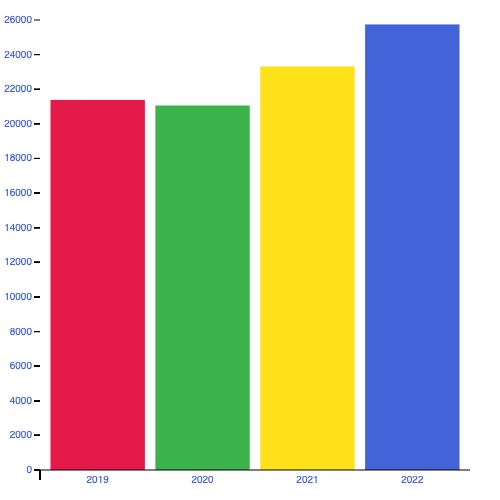

{
  call_tool: {
    messages: [
      ToolMessage {
        lc_serializable: true,
        lc_kwargs: {
          content: "generate_bar_chart response: Chart generated",
          name: "generate_bar_chart",
          tool_call_id: "call_JtKufRrliYqWtCjOE9bH8X22",
          additional_kwargs: {}
        },
        lc_namespace: [ "langchain_core", "messages" ],
        content: "generate_bar_chart response: Chart generated",
        name: "generate_bar_chart",
        additional_kwargs: {},
        tool_call_id: "call_JtKufRrliYqWtCjOE9bH8X22"
      }
    ]
  }
}
----
{
  ChartGenerator: {
    messages: [
      HumanMessage {
        lc_serializable: true,
        lc_kwargs: {
          lc_serializable: true,
          lc_kwargs: [Object],
          lc_namespace: [Array],
          content: "Here is the bar chart representing the US GDP over the past 3 years, including the GDP value for 202"... 395 more characters,
          name: "ChartGenerator",
          additional_kwargs: [Objec

In [13]:
const streamResults = await graph.stream(
  {
    messages: [
      new HumanMessage({
        content:
          "Generate a bar chart of the US gdp over the past 3 years.",
      }),
    ],
  },
  { recursionLimit: 150 }
);
for await (const output of await streamResults) {
  if (!output?.__end__) {
    console.log(output);
    console.log("----");
  }
}
